Code wird auch regelmäßig bei https://github.com/EvanderCorvus/AgentSimulation updated.


In [57]:
import torch as tr
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [58]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)
tr.set_default_dtype(tr.float)
tr.set_default_device(device)

Die Simulation befasst 256 "Agenten", die parallel lernen. Deren positionen wird gesamt in einer instanz der klasse Agent() gegeben. Forward ist hatt dann einen input von shape [4,256] und der Output auch (Ist dann der Q wert für jede Aktion für jeden der 256 Agenten).
Jede Episode hat eine vorgegebene anzahl an schritten, und ein Agent wird über mehrere Episoden trainiert. D.h. Er fängt wieder von Vorne an aber die weights bleiben. Die Loss wird dann über MSE von allen Agenten durchgeführt.


In [59]:
#hyperparameters
batch_size = 256
epoch = 10
t_update = 10
g = 0.6
max_steps = 100

Diese Funktion ersetzt Indizes (argmax(Q)) mit dem entsprechenden Bewegungsvektor.

In [60]:
def d(L,a=1):
    direction_mapping = [
        tr.tensor([0,1],dtype=tr.float).to(device), #up
        tr.tensor([0,-1],dtype=tr.float).to(device),#down
        tr.tensor([-1,0],dtype=tr.float).to(device), #left
        tr.tensor([1,0],dtype=tr.float).to(device) #right
    ]
    return tr.stack(direction_mapping).to(device)[L]*a


In [61]:
#Agent Class
class Agent(nn.Module):
    def __init__(self, x, y):#initialize agent at location (-0.5,-0.5) with bias 0
        super(Agent, self).__init__()
        self.x=x #x coordinate
        self.y=y #y coordinate
        self.input = nn.Linear(4, 64,dtype=tr.float) #input layer
        self.hidden1 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        self.hidden2 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        self.hidden3 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden4 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden5 = nn.Linear(64, 32, dtype = tr.float) #hidden layer
        self.output = nn.Linear(64, 4,dtype=tr.float) #output layer
        self.activation = nn.LeakyReLU() #activation function

    def forward(self, x): #forward pass
        x1 = self.activation(self.input(x))
        x2 = self.activation(self.hidden1(x1))
        x3 = self.activation(self.hidden2(x2))
        x4 = self.activation(self.hidden3(x3))
        # x5 = self.activation(self.hidden4(x4))
        # x6 = self.activation(self.hidden5(x5))
        x7 = self.output(x4)
        return x7
    

    def move(self,Q,e): 

        L=tr.argmax(Q,dim=1)
        random_vector = tr.rand(L.shape,dtype=tr.float).to(device)
        bool_vector = random_vector<e
        #randomly choose action with probability e
        L[bool_vector] = tr.randint(0,4,(1,),dtype=tr.int64).to(device) 
        a = tr.tensor(0.0357,dtype=tr.float).to(device)
        dr = d(L,a) 
        dx = dr[:,0]
        dy = dr[:,1]

        self.x+=dx
        self.y+=dy

def R(x,y,F,Q):#Reward Funktion ist die Distanz zum Ziel
    #if (round(x,2),round(y,2))==(0.5,0.): return 10
    # u = F/tr.norm(F)
    # td = d(tr.argmax(Q))
    # dr = td*0.0357
    # e = td - u/tr.norm(td-u) #unit vector that when summed with F is parallel to td
    # v = e + F
    # dt = 0.0357/(tr.dot(v,dr))
    #return -dt.item()/1000
   
    dist = tr.stack([x-0.5,y],dim=1).to(device)
    return -tr.norm(dist,dim=1)

Um den Lernprozess zu stabilisieren, wird ein target Network benutzt, welches nur jede 100 schritte auf den current agent synchronisiert wird. Mit der wird Q(s',a') berechnet. Aufgrund der Parallelisierung ist greedy-epsilon nicht eingebaut.
Das Kraftfeld hier ist F=(-y,0) aber es wird gar nicht in der reward funktion eingebracht also noch ist das keine nützliche Infomation für das NN.

In [62]:
#Simulation Setup
def episode(agent,t_agent,t_update, max_steps,g,optimizer):
    
    X,Y = agent.x,agent.y
    for dT in range(max_steps):
        optimizer.zero_grad()#zero gradients

        if dT%t_update==0:#update target agent every 100 steps
            t_agent.load_state_dict(agent.state_dict())


        state = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q1 = agent.forward(state)
        e = 1-dT/max_steps #epsilon greedy
        agent.move(Q1,e)

        state2 = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q2 = t_agent.forward(state2)#.transpose(0,1)) #Q value of target agent
        
        F = tr.stack([-agent.y,tr.zeros(agent.y.shape,dtype=tr.float).to(device)]).to(device)

        maxQ1 = tr.max(Q1,dim=1)[0]
        maxQ2 = tr.max(Q2,dim=1)[0]

        target = R(agent.x, agent.y, F, Q1) + g*maxQ2 #target Q value
        criterion = nn.MSELoss()

        loss = criterion(target,maxQ1) #custom_loss(target,tr.max(Q1,dim=1)[0])      #loss


        #backpropagate
        loss.backward()

        #update weights                         
        optimizer.step()   

        #save data to track agent                    
        newX = X.reshape(batch_size,-1)
        newY = Y.reshape(batch_size,-1)
        newx = agent.x[:,None]
        newy = agent.y[:,None]
       
        X = tr.cat((newX,newx),dim=1)
        Y = tr.cat((newY,newy),dim=1)

    
    return X,Y



In der Simulation werden die Startwerte Gaußverteilt mit mean (-0.5,0) und std 1/10 gesampled (für Robustheit).

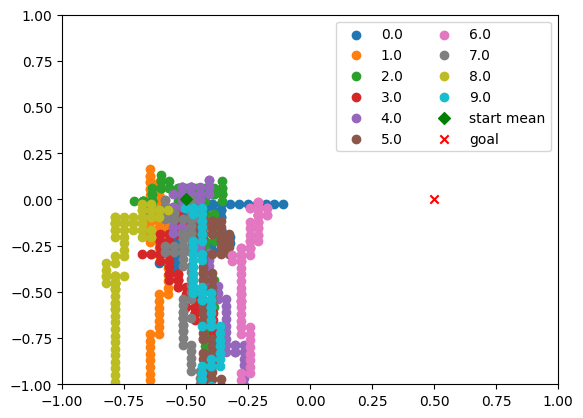

In [63]:
#Simulation
mu, sig = -0.5, 0.1
x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
agent = Agent(x,y).to(device)

t_agent = Agent(x,y).to(device)
t_agent.load_state_dict(agent.state_dict()) #copies weights from agent to t_agent
t_agent.eval()


optimizer = tr.optim.Adam(agent.parameters(), lr=0.001)

for i in range(epoch):
    X,Y = episode(agent, t_agent, t_update = t_update, max_steps = max_steps, g=g, optimizer=optimizer)
    agent.x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
    agent.y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
    x,y = X[0].detach().to('cpu').numpy(),Y[0].detach().to('cpu').numpy()
    
    plt.scatter(x,y,label=float(i))#,c=np.arange(len(x)),cmap='viridis')
    
    
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(-0.5,0,c='g',label='start mean',marker='D')    
plt.scatter(0.5,0,c='r',label='goal',marker='x')
plt.legend(ncol=2,loc='best')
plt.show()


Also am Bild ist zu erkennen, dass es am ende lernt, nur nach rechts zu gehen, aber auch dass es lernt :D